## Segmentação de Imagens de áreas desmatadas obtidas pelo Satélite Landsat8

In [3]:
from google.colab import drive
# 1. Montar o Google Drive
print("Montando o Google Drive...")
drive.mount('/content/drive')


Montando o Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install git+https://github.com/MIT-AI-Accelerator/multiearth-challenge

  Cloning https://github.com/MIT-AI-Accelerator/multiearth-challenge to /tmp/pip-req-build-tijdxasd
  Running command git clone --filter=blob:none --quiet https://github.com/MIT-AI-Accelerator/multiearth-challenge /tmp/pip-req-build-tijdxasd
  Resolved https://github.com/MIT-AI-Accelerator/multiearth-challenge to commit 21cd2c7f2b5ea7cd8bba5fa49af5fc295e7cf3c9
  Preparing metadata (setup.py) ... canceled
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/p

In [4]:
#Importando bibliotecas
import pkg_resources
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from skimage import filters, morphology
from skimage.transform import resize
import pandas as pd
from multiearth_challenge.datasets import segmentation_dataset as sd
from tqdm import tqdm


In [6]:

data_dir = Path("./drive/MyDrive/testes/")
source_files = [data_dir / "landsat8_train.nc"]
segmentation_files = [data_dir / "deforestation_train.nc"]

# 1. Bandas de detecção da imagem de entrada
# As bandas disponíveis são
# ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10', 'QA_PIXEL']
# Selecionaremos as bandas no espectro de luz visível
source_bands = {"Landsat-8": ["SR_B4", "SR_B3", "SR_B2"]} # RGB

# 2. Cobertura de nuvens (em pct) [min, max].
source_cloud_coverage = (0, 0)

# 3. Janela temporal ao redor da data do target
# Como o tempo de revisita do landsat8 é de 16 dias, usaremos esse valor
source_date_window = (-16, 16)

# 4. Se 'True', gera um par (source, target) para cada source compatível, false retorna uma lista das imagens compatíveis
# True gera "duplicação" de targets, então usamos false e lidamos com a lista posteriormente
single_source_image = False

# 5. Se não forem encontrados nenhum dado, retorna erro (na pratica nesse caso não precisa se preocupar)
error_on_empty = True
# --- 1. Create the Initial Dataset ---
# Note: If you modified segmentation_dataset.py to accept 'Landsat-8' as a
# segmentation source, this will work. Otherwise, it might error here.
dataset = sd.ImageSegmentationDataset(
    source_files=source_files,
    segmentation_files=segmentation_files,
    source_bands=source_bands,
    merge_source_bands=True,
    source_cloud_coverage=source_cloud_coverage,
    source_date_window=source_date_window,
    single_source_image=single_source_image,
)

print(f"Encontrados {len(dataset)} targets com ao menos uma imagem compatível.")

Encontrados 10224 targets com ao menos uma imagem compatível.


# Antes


 Define os caminhos para os arquivos de dados de amostra
 Estes são os arquivos de entrada (imagem de satélite) e alvo (máscara de segmentação).
source_files = [pkg_resources.resource_filename("multiearth_challenge", "data/sample_dataset/landsat8_sample.nc")]
segmentation_files = [pkg_resources.resource_filename("multiearth_challenge", "data/sample_dataset/deforestation_sample.nc")]


Bandas que serão utlizadas, neste caso RGB
Landsat-8, bandas RGB: Vermelho (SR_B4), Verde (SR_B3) e Azul (SR_B2).
source_bands = {"Landsat-8": ['SR_B4', 'SR_B3', 'SR_B2']}

Configuração do Dataset com as imagens RGB
 O parâmetro mais importante `merge_source_bands=True`, que combina
 as 3 bandas (R, G, B) em uma única imagem de 3 canais.
dataset = sd.ImageSegmentationDataset(
    source_files=source_files,
    segmentation_files=segmentation_files,
    source_bands=source_bands,
    merge_source_bands=True,  ESSENCIAL: Junta as bandas em uma imagem RGB
    source_cloud_coverage=(0.0, 0.0), # Pega apenas imagens sem nuvens
    source_date_window=(-16, 16),
    single_source_image=True,
    error_on_empty=True,
)

print(f"Número de pares (imagem RGB / máscara) encontrados: {len(dataset)}")


#### Redimensionando as Mascáras

In [5]:

processed_sources = []
processed_masks = []
new_dims = (85, 85)

for i in range(3):
    source_data_list, target_data = dataset[i]

    if not source_data_list:
        continue

    # 1. Voltando na idefrom skimage.transform import resizeia de single_source_image, como temos uma lista de imagens compatíveis, escolhemos a mais próxima em timestamp
    target_date = target_data['date']
    time_diffs = np.array([abs(s['date'] - target_date) for s in source_data_list])
    best_source_idx = np.argmin(time_diffs)
    best_source = source_data_list[best_source_idx]

    # 2. Subamostragem na máscara, 256x256 para 85x85
    original_mask = target_data['image'].squeeze()

    # Opções para manter a característica binária da mascara
    downscaled_mask = resize(
        original_mask,
        new_dims,
        order=0,
        preserve_range=True,
        anti_aliasing=False
    )

    downscaled_mask = downscaled_mask.astype(original_mask.dtype)

    # 3. Adicionar a fonte e máscara na lista
    processed_sources.append(best_source['image'])
    processed_masks.append(downscaled_mask)

print(f"\nProcessing complete. Created {len(processed_sources)} final image-mask pairs.")

# Transformar em nparrays
#final_sources = np.stack(processed_sources)
#final_masks = np.stack(processed_masks)

#print(f"\nShape final - Fonte: {final_sources.shape}")
print(f"Shape final - máscaras: {len(processed_masks)}")


Processing complete. Created 3 final image-mask pairs.
Shape final - máscaras: 3


In [6]:

def luminance(image):
    l = 0.2126 * image[:, :, 0] + 0.7152 * image[:, :, 1] + 0.0722 * image[:, :, 2]
    return l

# Função auxiliar para normalizar a imagem para visualização (valores entre 0 e 1)
def normalize(img):
    img = img.astype(np.float64)
    min_val = np.min(img)
    max_val = np.max(img)
    if max_val > min_val:
        img = (img - min_val) / (max_val - min_val)
    else:
        img = img * 0  # imagem preta se max==min
    return img


In [7]:

#Criando o vetor de imagens
vetor_img = []
#imagens cinza
imgs_cinza = []

#vetor para as mask
vetor_mask = []
#processa todas as imagens do dataset
for i,(source_data, target_data) in enumerate(tqdm(dataset, desc="Vetorizando Imagens")):
    rgb_image = source_data[0]["image"]  # (3, H, W)
    mask = target_data["image"]
    img_transp = rgb_image.transpose((1,2,0)) # converte para (H, W, 3)

    #normalizo a imagem com valores entre 0-1
    rgb_norm = normalize(img_transp)

    #vetor com imagens rgb
    vetor_img.append(rgb_norm)

    #imagens cinzas
    img_g = luminance(img_transp) #aplico a luminacia em img transporta e normalizada
    imgs_cinza.append(normalize(img_g))

    #acumulando as mascaras
    vetor_mask.append(mask.transpose((1,2,0)))


    if i>3:
      break

Vetorizando Imagens:   0%|          | 4/10224 [00:00<01:19, 127.76it/s]


In [8]:
def converter_uint8(img_float):
    #Converte uma imagem float [0, 1] para uint8 (0-255)
    return (img_float * 255).astype(np.uint8)

#Converte a lista de imagens RGB
imagens_rgb = [converter_uint8(img) for img in vetor_img]

#Converte a lista de imagens em tons de cinza
imagens_cinza = [converter_uint8(img) for img in imgs_cinza]



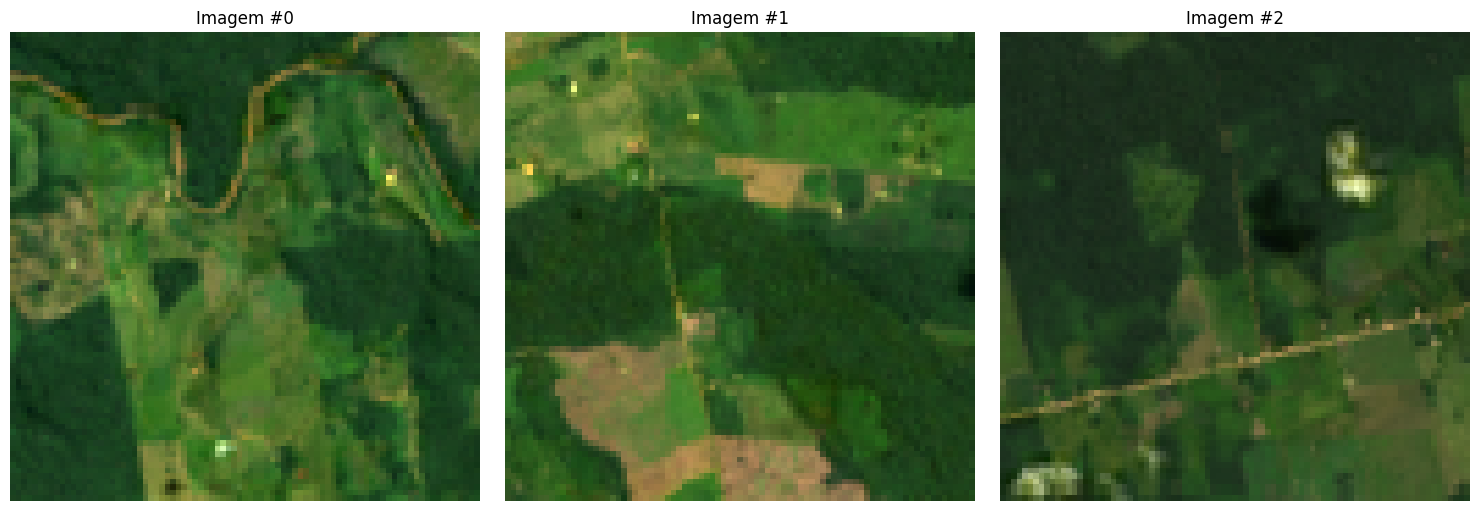

In [9]:
num_a_visualizar = min(3, len(imagens_rgb))
fig, axes = plt.subplots(1, num_a_visualizar, figsize=(5 *  num_a_visualizar, 5))
# Garante que 'axes' seja sempre uma lista, mesmo com num_a_visualizar=1
if num_a_visualizar == 1:
    axes = [axes]

for i in range(num_a_visualizar):
     # Transpõe para (H, W, 3) e normaliza para o intervalo [0,1] caso necessário
        img = imagens_rgb[i]
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Imagem #{i}")
        axes[i].axis("off")

plt.tight_layout()
plt.show()

In [10]:
len(imagens_cinza)

5

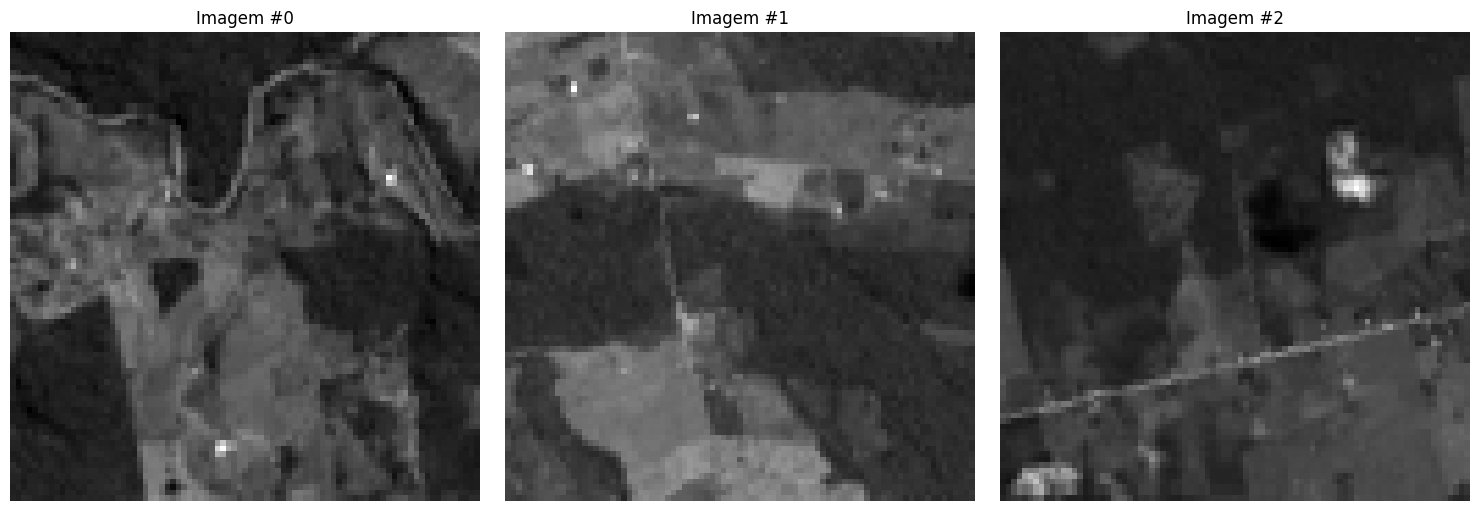

In [11]:
num_a_visualizar = min(3, len(imagens_cinza))
fig, axes = plt.subplots(1, num_a_visualizar, figsize=(5 *  num_a_visualizar, 5))
# Garante que 'axes' seja sempre uma lista, mesmo com num_a_visualizar=1
if num_a_visualizar == 1:
    axes = [axes]

for i in range(num_a_visualizar):
     # Transpõe para (H, W, 3) e normaliza para o intervalo [0,1] caso necessário
        img = imagens_cinza[i]
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Imagem #{i}")
        axes[i].axis("off")

plt.tight_layout()
plt.show()

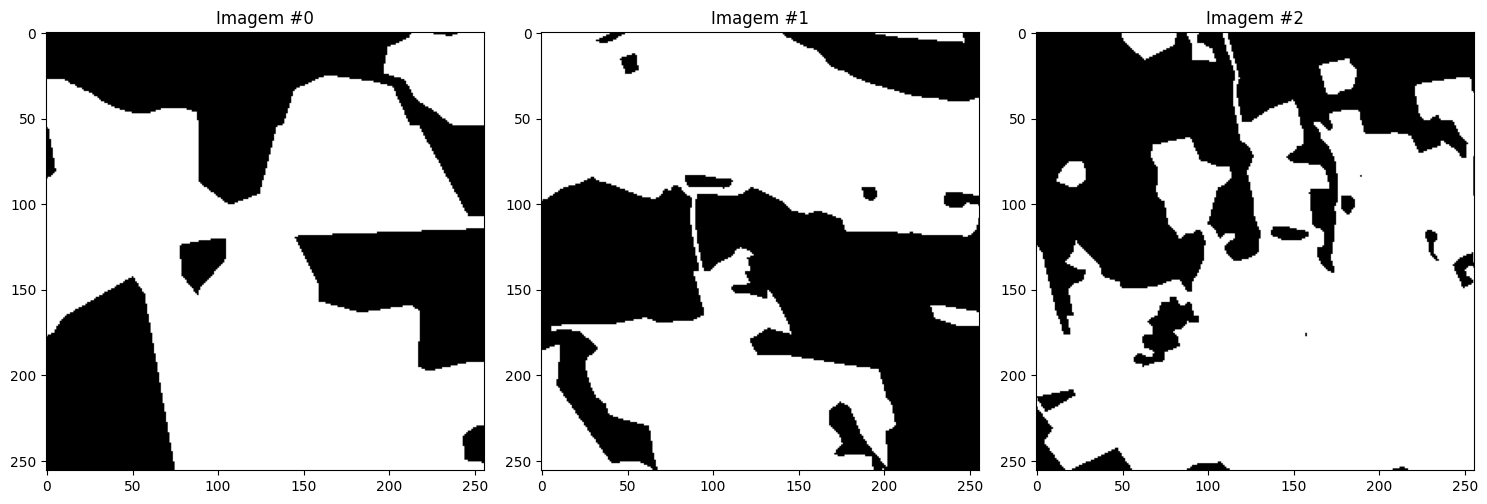

In [12]:
tam = min(3, len(vetor_mask))
fig, axes = plt.subplots(1, tam, figsize=(5 *  tam, 5))
# Garante que 'axes' seja sempre uma lista, mesmo com tam=1
if tam == 1:
    axes = [axes]

for i in range(tam):
    img = vetor_mask[i]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Imagem #{i}")
    axes[i].axis()

plt.tight_layout()
plt.show()

In [13]:
#Funções para plotars imagens lado a lado (2 e 3 ) e histogramas
def plot_2img(tg,img1,title1, img2, title2):
    plt.figure(figsize=(10,5))
    plt.suptitle(tg)

    # 1. Imagem original
    plt.subplot(1, 2, 1)
    plt.title(title1)
    plt.imshow(img1, cmap='gray')
    plt.axis('off')

    # 2. Imagem binarizada
    plt.subplot(1,2,2)
    plt.title(title2)
    plt.imshow(img2, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def plot_3img(tg, img1, t1, img2, t2, img3, t3):

    # Mostra lado a lado
    plt.figure(figsize=(15, 5))
    plt.suptitle(tg)

    plt.subplot(1, 3, 1)
    plt.title(t1)
    plt.imshow(img1, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(t2)
    plt.imshow(img2, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(t3)
    plt.imshow(img3, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def plot_imagens(imagens, titulos=None, titulo_geral=None, cmap='gray'):
    tam = len(imagens)
    if titulos is None:
        titulos = [''] * 4  # títulos vazios por padrão

    plt.figure(figsize=(5* tam, 5))

    if titulo_geral:
        plt.suptitle(titulo_geral, fontsize=16, y=1.05)

    for i in range(tam):
        plt.subplot(1, tam, i + 1)
        plt.imshow(imagens[i], cmap=cmap)
        plt.title(titulos[i])
        plt.axis()

    plt.tight_layout()
    plt.show()




#### Aplicação de filtros nas imagens

In [ ]:
##FUNCÕES DE REALCE
#Histograma
#Computa a distribuição de intensidades de pixel em uma img
def histograma(img, tam):
    acumulador = np.zeros((tam,))
    h, w = img.shape
    for i in range(h):
        for j in range(w):
            acumulador[img[i, j]] += 1
    return acumulador

#Histograma Cumulativo
#Computa a proporcao de intensidades
def histo_cumulativo(h, L):
    acumulador = np.zeros((L,))
    acumulador[0] = h[0]
    for i in range(1, L):
        acumulador[i] = acumulador[i - 1] + h[i]
    return acumulador

#Funcao que aplica uma equalizacao no histograma
#T(z) = ((L-1)/ total_pixels) * Hc(z)
def transf(hc, img, total=None):

    h, w = img.shape
    L = 256  # níveis de cinza
    if total is None:
        total = float(h * w)
    new_img = np.zeros_like(img, dtype=np.uint8)
    aux = (L-1)/total
    for i in range(h):
        for j in range(w):
            z = img[i, j]
            new_val = aux * hc[z]
            new_img[i, j] = new_val

    return new_img.astype(np.uint8)

#Realiza a equalizacao de forma individual
def equaliza_indiv(imagens):
    img_eq =  []
    for img in imagens:
        h = histograma(img, 256)
        hc = histo_cumulativo(h, 256)
        img_eq.append(transf(hc, img))

    return img_eq

#realiza a equalizacao de forma conjunta, i.e, para n imagens
def equaliza_conj(imagens):
    h_conjunto = np.zeros(256)
    for img in imagens:
        h_conjunto += histograma(img, 256)

    hc_conjunto = histo_cumulativo(h_conjunto, 256)
    total_pixels = sum(img.size for img in imagens)  # total de pixels do conjunto
    imagens_eq = [transf(hc_conjunto, img, total=total_pixels) for img in imagens]

    return imagens_eq, hc_conjunto

def plot_histograms(images, titles, main_title):
    plt.figure(figsize=(15, 10))

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(2, len(images), i+1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')

        plt.subplot(2, len(images), i+1+len(images))
        hist = histograma(img, 256)
        plt.bar(range(256), hist)
        plt.title(f'Histograma {title}')

    plt.suptitle(main_title)
    plt.tight_layout()
    plt.show()

In [ ]:
imgs_eq = []
imgs_eq = equaliza_indiv(imagens_cinza)
plot_imagens(imgs_eq, ['Imagem 1', 'Imagem 2','Imagem 3'], "Imagem Equalizadas")

Aplicando o filtro de Minimos QUadrados Restritivos


In [ ]:
#Filtro de ruído
def gaussian_filter(k=3, sigma=1.0):
    arx = np.arange((-k//2) + 1.0, (k//2) + 1.0)
    x,y = np.meshgrid(arx, arx)
    filt = np.exp(-(1/2) * (np.square(x) + np.square(y)) / np.square(sigma))

    return np.array(filt/np.sum(filt))

#Filtro Laplaciano
def operador_laplaciano():
    return np.array([[0,-1,  0],
                     [-1, 4, -1],
                     [0, -1, 0]])

def pad_to_shape(arr, shape):
    """Faz padding de arr para o shape fornecido (centrado)"""
    pad_y = shape[0] - arr.shape[0]
    pad_x = shape[1] - arr.shape[1]
    pad_top = pad_y // 2
    pad_bottom = pad_y - pad_top
    pad_left = pad_x // 2
    pad_right = pad_x - pad_left
    return np.pad(arr, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')

#Filtro de Minimos Quadrados Restritos
def filter_min_quad_rest(sigma, tam_f, img_deg, gama):
    #criando os filtros de degradação(gaussiano) e limitante(laplace)
    laplace = operador_laplaciano()
    filt_deg = gaussian_filter(k = tam_f, sigma=sigma)

    #realizando o padding nos filtros
    filt_h_pad = pad_to_shape(filt_deg, img_deg.shape)
    laplace_pad = pad_to_shape(laplace, img_deg.shape)


    #aplicando a tf na imagem e filtros
    img_deg_ft = np.fft.fft2(img_deg)
    filt_h = np.fft.fft2(filt_h_pad)
    filt_h_conj = np.conjugate(filt_h)
    op_laplace = np.fft.fft2(laplace_pad)

    #realizando a filtragem do dominio da frequencia ( produto na frequencia)
    result = (filt_h_conj / (np.abs(filt_h) ** 2 + gama *( np.abs(op_laplace) ** 2))) * img_deg_ft

    #aplicando a tf inversa e voltando pro dominio real
    img_result = np.fft.ifft2(result)
    img_result = np.fft.ifftshift(img_result)
    img_result = np.real(img_result)

    return((normalize(img_result)*255).astype(np.uint8))



In [ ]:
gama = 0.5
tam_f = 5
sigm = 0.01
imgs_fmqr = [ ]
for img in imagens_cinza:
    img_filt = filter_min_quad_rest(sigm, tam_f, img, gama)
    imgs_fmqr.append(img_filt)

In [ ]:

plot_imagens(imgs_fmqr, ['Imagem 1', 'Imagem 2','Imagem 3'], "Imagem Suvaizadas com Filtro de Minimos Quadrados Restritivos")


#### Correções Gamma

Será aplicados em:
* Imagens Originais
* Imagens equalizadas
* Imagens filtradas com Minimos Quadrados restritivos

In [ ]:
#Define a equação do realce gama
def realce_gama(img, gama):
    img_gama = img**(1/gama)
    img_gama = normalize(img_gama)
    img_norm = (img_gama * 255).astype(np.uint8)

    return img_norm
#Aplica a correção gama na imagem
def correc_gamma(imagem, gama):
    imagens_gama = realce_gama(imagem, gama)
    return imagens_gama

In [ ]:
gama1 = 0.75
gama2 = 2.0
io_gama1 = [correc_gamma(img,gama1) for img in imagens_cinza]
io_gama2 = [correc_gamma(img,gama2) for img in imagens_cinza]

plot_imagens(io_gama1, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Imagem Originais com correção gamma = {gama1}")
plot_imagens(io_gama2, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Imagem Originais com correção gamma = {gama2}")

In [ ]:
gama1 = 0.75
gama2 = 2.0
ieq_gama1 = [correc_gamma(img,gama1) for img in imgs_eq]
ieq_gama2 = [correc_gamma(img,gama2) for img in imgs_eq]

plot_imagens(ieq_gama1, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Imagem Equalizadas com correção gamma = {gama1}")
plot_imagens(ieq_gama2, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Imagem Equalizadas com correção gamma = {gama2}")

In [ ]:
gama1 = 0.75
gama2 = 2.0
ifilt_gama1 = [correc_gamma(img,gama1) for img in imgs_fmqr]
ifilt_gama2 = [correc_gamma(img,gama2) for img in imgs_fmqr]

plot_imagens(ifilt_gama1, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Imagem FMQR com correção gamma = {gama1}")
plot_imagens(ifilt_gama2, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Imagem FMQR com correção gamma = {gama2}")

In [ ]:
def metodo_otsu(imagem):
    #calculando o histograma da imagem
    histo, bin_edges = np.histogram(imagem, bins=np.arange(257))

    #calculando o tamanho da imagem
    total_pixels = imagem.size
    current_max, limiar = 0,0

    #calculando a media global da imagem
    media_global = np.sum(histo * np.arange(256))/total_pixels

    #variaveis auxiliares
    peso_fundo, media_fundo = 0, 0
    soma_fundo = 0

    for i in range(256):
        #peso de fundo
        peso_fundo += histo[i]

        if peso_fundo == 0:
            continue

        #veirificando o primeiro plano
        peso_plan1 =  total_pixels - peso_fundo

        if peso_plan1 == 0:
            break

        #media do fundo
        soma_fundo += i * histo[i]
        media_fundo = soma_fundo / peso_fundo

        #media primeiro plano
        media_plan1 =(media_global * total_pixels - soma_fundo)/peso_plan1

        #calculando a variancia intra_classe
        var_interclas = peso_fundo * peso_plan1 * (media_fundo - media_plan1) ** 2

        #maxima var e limiarização
        if var_interclas > current_max:
            current_max = var_interclas
            limiar = i

    return limiar


In [ ]:
def aplicar_otsu(list_img):
    # Recebe uma lista de imagens e retorna uma outra lista com imagens binarias
    imagens_bin = []
    # Usando tqdm para visualizar o progresso
    for img in tqdm(list_img, desc="Aplicando Otsu"):
        # Calcula o limiar para a imagem atual
        limiar = metodo_otsu(img)
        # Binariza a imagem com base no limiar e adiciona à lista
        bin_img = (img > limiar).astype(np.uint8) * 255
        imagens_bin.append(bin_img)
    return imagens_bin

In [ ]:
plot_histograms(imgs_fmqr, ['Imagem 1', 'Imagem 2','Imagem 3'] , 'Histogramas')
plot_histograms(ifilt_gama1, ['Imagem 1', 'Imagem 2','Imagem 3'] , 'Histogramas')
plot_histograms(ifilt_gama2, ['Imagem 1', 'Imagem 2','Imagem 3'] , 'Histogramas')

In [ ]:
io_otsu0 = aplicar_otsu(imagens_cinza)
io_otsu1 = aplicar_otsu(io_gama1)
io_otsu2 = aplicar_otsu(io_gama2)

plot_imagens(io_otsu0, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Otsu nas imagens orginais")
plot_imagens(io_otsu1, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Otsu nas io com gama = 0.75")
plot_imagens(io_otsu2, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Otsu nas io com gama = 2.0")



##### Imagem Equalizada com Correção Gama

In [ ]:
ieq_otsu0 = aplicar_otsu(imagens_cinza)
ieq_otsu1 = aplicar_otsu(ieq_gama1)
ieq_otsu2 = aplicar_otsu(ieq_gama2)

plot_imagens(ieq_otsu0, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Otsu nas imagens equalizadas")
plot_imagens(ieq_otsu1, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Otsu nas ieq com gama = 0.75")
plot_imagens(ieq_otsu2, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Otsu nas ieq com gama = 2.0")



In [ ]:
if_otsu0 = aplicar_otsu(imgs_fmqr)
plot_imagens(if_otsu0, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Otsu nas imagens FMQR")


In [ ]:
if_otsu0 = aplicar_otsu(imgs_fmqr)
if_otsu1 = aplicar_otsu(ifilt_gama1)
if_otsu2 = aplicar_otsu(ifilt_gama2)

plot_imagens(if_otsu0, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Otsu nas imagens FMQR")
plot_imagens(if_otsu1, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Otsu nas if com gama = 0.75")
plot_imagens(if_otsu2, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Otsu nas if com gama = 2.0")



#### Segmentação com Metodo de Yen

Utilizando a biblioteca skimage

In [ ]:
def aplicar_Yen(list_img):
    imagens_bin = []
    for img in tqdm(list_img, desc="Binarizando com Yen"):

        #calculo do limiar pelo skimage
        limiar = filters.threshold_yen(img)

        #cria a img binaria
        mascara_booleana = (img > limiar)

        #normaliza pra 0-255
        imagem_final = mascara_booleana.astype(np.uint8) * 255
        imagens_bin.append(imagem_final)


    return imagens_bin

In [ ]:
#Aplicando Yen em imagens filtrada com correções gama
io_Yen0 = aplicar_Yen(imagens_cinza)
io_Yen1 = aplicar_Yen(io_gama1)
io_Yen2 = aplicar_Yen(io_gama2)

plot_imagens(io_Yen0, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Yen nas imagens originais")
plot_imagens(io_Yen1, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Yen nas io com gama = 0.75")
plot_imagens(io_Yen2, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Yen nas io com gama = 2.0")



In [ ]:
#Aplicando Yen em imagens filtrada com correções gama
if_Yen0 = aplicar_Yen(imgs_fmqr)
if_Yen1 = aplicar_Yen(ifilt_gama1)
if_Yen2 = aplicar_Yen(ifilt_gama2)

plot_imagens(if_Yen0, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Yen nas imagens FMQR")
plot_imagens(if_Yen1, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Yen nas if com gama = 0.75")
plot_imagens(if_Yen2, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Yen nas if com gama = 2.0")



#### Aplicando Morfologia Matematica

In [ ]:
def open_close(img, selem):

    #realizando o processo de abertura ( erosão + dilatação)
    img_opened = morphology.binary_opening(img,selem)

    #realizando o processo de fechamentro (dilatação + erosão)
    img_result = morphology.closing(img_opened, selem)

    #retorna uma nova img
    return img_result

def aplicar_Morph(list_img, selem):
    # Recebe uma lista de imagens e retorna uma outra lista com imagens
    imgs_morph = []
    # Usando tqdm para visualizar o progresso
    for img in tqdm(list_img, desc="Aplicando Morfologia Matemática (Abertura e  Fechamento)"):
        morph = open_close(img, selem)
        imgs_morph.append(morph)
    return imgs_morph

In [ ]:
selem = morphology.square(4)
io_m0 = aplicar_Morph(io_otsu0,selem)
io_m1 = aplicar_Morph(io_otsu1,selem)
io_m2 = aplicar_Morph(ieq_otsu2,selem)

plot_imagens(io_m0, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Morfologia Matematica(O&C) em io_Otsu0")
plot_imagens(io_m1, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Morfologia Matematica(O&C) em io_Otuso1")
plot_imagens(io_m2, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Morfologia Matematica(O&C) em io_Otuso2")



In [ ]:
selem = morphology.square(4)
ieq_m0 = aplicar_Morph(ieq_otsu0,selem)
ieq_m1 = aplicar_Morph(ieq_otsu1,selem)
ieq_m2 = aplicar_Morph(ieq_otsu2,selem)

plot_imagens(ieq_m0, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Morfologia Matematica(O&C) em ieq_Otsu0")
plot_imagens(ieq_m1, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Morfologia Matematica(O&C) em ieq_Otuso1")
plot_imagens(ieq_m2, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Morfologia Matematica(O&C) em ieq_Otuso2")


In [ ]:
selem = morphology.square(4)
if_m0 = aplicar_Morph(if_otsu0,selem)
if_m1 = aplicar_Morph(if_otsu1,selem)
if_m2 = aplicar_Morph(if_otsu2,selem)

plot_imagens(if_m0, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Morfologia Matematica(O&C) em if_Otsu0")
plot_imagens(if_m1, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Morfologia Matematica(O&C) em if_Otuso1")
plot_imagens(if_m2, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Morfologia Matematica(O&C) em if_Otuso2")


#Pipeline

In [7]:
def luminance(image):
    l = 0.2126 * image[:, :, 0] + 0.7152 * image[:, :, 1] + 0.0722 * image[:, :, 2]
    return l

# Função auxiliar para normalizar a imagem para visualização (valores entre 0 e 1)
def normalize(img):
    img = img.astype(np.float64)
    min_val = np.min(img)
    max_val = np.max(img)
    if max_val > min_val:
        img = (img - min_val) / (max_val - min_val)
    else:
        img = img * 0  # imagem preta se max==min
    return img

def converter_uint8(img_float):
    #Converte uma imagem float [0, 1] para uint8 (0-255)
    return (img_float * 255).astype(np.uint8)

In [8]:
##FUNCÕES DE REALCE
#Histograma
#Computa a distribuição de intensidades de pixel em uma img
def histograma(img, tam):
    acumulador = np.zeros((tam,))
    h, w = img.shape
    for i in range(h):
        for j in range(w):
            acumulador[img[i, j]] += 1
    return acumulador

#Histograma Cumulativo
#Computa a proporcao de intensidades
def histo_cumulativo(h, L):
    acumulador = np.zeros((L,))
    acumulador[0] = h[0]
    for i in range(1, L):
        acumulador[i] = acumulador[i - 1] + h[i]
    return acumulador

#Funcao que aplica uma equalizacao no histograma
#T(z) = ((L-1)/ total_pixels) * Hc(z)
def transf(hc, img, total=None):

    h, w = img.shape
    L = 256  # níveis de cinza
    if total is None:
        total = float(h * w)
    new_img = np.zeros_like(img, dtype=np.uint8)
    aux = (L-1)/total
    for i in range(h):
        for j in range(w):
            z = img[i, j]
            new_val = aux * hc[z]
            new_img[i, j] = new_val

    return new_img.astype(np.uint8)

#Realiza a equalizacao de forma individual
def equaliza_indiv(imagens):
    img_eq =  []
    for img in imagens:
        h = histograma(img, 256)
        hc = histo_cumulativo(h, 256)
        img_eq.append(transf(hc, img))

    return img_eq

#realiza a equalizacao de forma conjunta, i.e, para n imagens
def equaliza_conj(imagens):
    h_conjunto = np.zeros(256)
    for img in imagens:
        h_conjunto += histograma(img, 256)

    hc_conjunto = histo_cumulativo(h_conjunto, 256)
    total_pixels = sum(img.size for img in imagens)  # total de pixels do conjunto
    imagens_eq = [transf(hc_conjunto, img, total=total_pixels) for img in imagens]

    return imagens_eq, hc_conjunto

def plot_histograms(images, titles, main_title):
    plt.figure(figsize=(15, 10))

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(2, len(images), i+1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')

        plt.subplot(2, len(images), i+1+len(images))
        hist = histograma(img, 256)
        plt.bar(range(256), hist)
        plt.title(f'Histograma {title}')

    plt.suptitle(main_title)
    plt.tight_layout()
    plt.show()

In [9]:
#Filtro de ruído
def gaussian_filter(k=3, sigma=1.0):
    arx = np.arange((-k//2) + 1.0, (k//2) + 1.0)
    x,y = np.meshgrid(arx, arx)
    filt = np.exp(-(1/2) * (np.square(x) + np.square(y)) / np.square(sigma))

    return np.array(filt/np.sum(filt))

#Filtro Laplaciano
def operador_laplaciano():
    return np.array([[0,-1,  0],
                     [-1, 4, -1],
                     [0, -1, 0]])

def pad_to_shape(arr, shape):
    """Faz padding de arr para o shape fornecido (centrado)"""
    pad_y = shape[0] - arr.shape[0]
    pad_x = shape[1] - arr.shape[1]
    pad_top = pad_y // 2
    pad_bottom = pad_y - pad_top
    pad_left = pad_x // 2
    pad_right = pad_x - pad_left
    return np.pad(arr, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')

#Filtro de Minimos Quadrados Restritos
def filter_min_quad_rest(sigma, tam_f, img_deg, gama):
    #criando os filtros de degradação(gaussiano) e limitante(laplace)
    laplace = operador_laplaciano()
    filt_deg = gaussian_filter(k = tam_f, sigma=sigma)

    #realizando o padding nos filtros
    filt_h_pad = pad_to_shape(filt_deg, img_deg.shape)
    laplace_pad = pad_to_shape(laplace, img_deg.shape)


    #aplicando a tf na imagem e filtros
    img_deg_ft = np.fft.fft2(img_deg)
    filt_h = np.fft.fft2(filt_h_pad)
    filt_h_conj = np.conjugate(filt_h)
    op_laplace = np.fft.fft2(laplace_pad)

    #realizando a filtragem do dominio da frequencia ( produto na frequencia)
    result = (filt_h_conj / (np.abs(filt_h) ** 2 + gama *( np.abs(op_laplace) ** 2))) * img_deg_ft

    #aplicando a tf inversa e voltando pro dominio real
    img_result = np.fft.ifft2(result)
    img_result = np.fft.ifftshift(img_result)
    img_result = np.real(img_result)

    return((normalize(img_result)*255).astype(np.uint8))


#Define a equação do realce gama
def realce_gama(img, gama):
    img_gama = img**(1/gama)
    img_gama = normalize(img_gama)
    img_norm = (img_gama * 255).astype(np.uint8)

    return img_norm
#Aplica a correção gama na imagem
def correc_gamma(imagem, gama):
    imagens_gama = realce_gama(imagem, gama)
    return imagens_gama
def metodo_otsu(imagem):
    #calculando o histograma da imagem
    histo, bin_edges = np.histogram(imagem, bins=np.arange(257))

    #calculando o tamanho da imagem
    total_pixels = imagem.size
    current_max, limiar = 0,0

    #calculando a media global da imagem
    media_global = np.sum(histo * np.arange(256))/total_pixels

    #variaveis auxiliares
    peso_fundo, media_fundo = 0, 0
    soma_fundo = 0

    for i in range(256):
        #peso de fundo
        peso_fundo += histo[i]

        if peso_fundo == 0:
            continue

        #veirificando o primeiro plano
        peso_plan1 =  total_pixels - peso_fundo

        if peso_plan1 == 0:
            break

        #media do fundo
        soma_fundo += i * histo[i]
        media_fundo = soma_fundo / peso_fundo

        #media primeiro plano
        media_plan1 =(media_global * total_pixels - soma_fundo)/peso_plan1

        #calculando a variancia intra_classe
        var_interclas = peso_fundo * peso_plan1 * (media_fundo - media_plan1) ** 2

        #maxima var e limiarização
        if var_interclas > current_max:
            current_max = var_interclas
            limiar = i

    return limiar

def open_close(img, selem):

    #realizando o processo de abertura ( erosão + dilatação)
    img_opened = morphology.binary_opening(img,selem)

    #realizando o processo de fechamentro (dilatação + erosão)
    img_result = morphology.closing(img_opened, selem)

    #retorna uma nova img
    return img_result

def aplicar_Morph(list_img, selem):
    # Recebe uma lista de imagens e retorna uma outra lista com imagens
    imgs_morph = []
    # Usando tqdm para visualizar o progresso
    for img in tqdm(list_img, desc="Aplicando Morfologia Matemática (Abertura e  Fechamento)"):
        morph = open_close(img, selem)
        imgs_morph.append(morph)
    return imgs_morph

In [21]:
from dataclasses import dataclass, field
import pandas as pd
import numpy as np
from typing import List
from sklearn.metrics import jaccard_score


def etapa_cinza(source_data,target_data):
  new_dims = (85,85)
  rgb_image = source_data[0]["image"]  # (3, H, W)
  img_transp = rgb_image.transpose((1,2,0)) # converte para (H, W, 3)
  mask = target_data["image"]
  original_mask = mask.squeeze()

  # Opções para manter a característica binária da mascara
  downscaled_mask = resize(
      original_mask,
      new_dims,
      order=0,
      preserve_range=True,
      anti_aliasing=False
  )

  downscaled_mask = downscaled_mask.astype(original_mask.dtype)
  mask = downscaled_mask


  rgb   = converter_uint8(normalize(img_transp))
  cinza = converter_uint8(normalize(luminance(img_transp)))
  # mask.transpose((1,2,0))
  return rgb,cinza,mask

def etapa_filtros(img_cinza,gamma=0.5,sigma=0.01,tam_f=5):
  img_eq = equaliza_indiv([img_cinza])[0]
  img_mq = filter_min_quad_rest(sigma, tam_f, img_cinza, gamma)
  return img_eq,img_mq,img_cinza ## equalizada, minquad, original

def etapa_correcao(img_cinza,gammas:list[float]):
  return [correc_gamma(img_cinza,gamma) for gamma in gammas]

def etapa_otsu(img_cinza):
  limiar = metodo_otsu(img_cinza)
  bin_img = (img_cinza > limiar)#.astype(np.uint8) * 255 # Binariza a imagem com base no limiar
  return bin_img

def etapa_morfologia(img_bin,morf_obj):
  return open_close(img_bin,morf_obj)

def etapa_score(true_mask,img_bin,method):
  if method=='jaccard':
    return jaccard_score(true_mask.flatten(),img_bin.flatten(),zero_division=1)
  else:
    raise ValueError(f"Score method [{method}] not allowed")






type2filter = {0:'original',1:'equalizada',2:'min quad'}
filter2type = {value:key for key,value in type2filter.items()}


@dataclass
class IMG:
  _img: List[tuple[np.ndarray,str]]  # armazena a lista real
  filter_type:int
  gamma:float=None
  morf_applied:bool=False
  score_jaccard:float=None
  append_allowed:bool=False ## define como substitui o img

  @property
  def img(self):
    return self._img[-1][0] if self._img else None

  @img.setter
  def img(self, value):
      if not (isinstance(value,list) or isinstance(value,tuple)):
        value = (value,self._img[-1][1])
      if self.append_allowed and self._img:
          self._img.append(value)
      else:
          self._img = [value]
  def get_imgs(self):
    return self._img

  def to_dict(self):
    return {'gamma':self.gamma,
     'filter':type2filter[self.filter_type],
     'morf_applied':self.morf_applied,
     'score_jaccard':self.score_jaccard}
  def __str__(self):
    return f"""
    Descricoes: {[img[1] for img in self._img]}
    Gamma: {self.gamma}
    Filter: {type2filter[self.filter_type]}
    IsMorf: {self.morf_applied}
    """


def pipeline(source_data,target_data,morf_obj,gamma_values=[0.75,2.0,1.0],
             gamma_filtro=0.5,sigma_filtro=0.01,filtro_tamf=5,verbose=False,return_imgs=False):
  img_rgb, img_cinza, true_mask = etapa_cinza(source_data,target_data)

  '''## etapa filtros
  if verbose: print("Etapa filtros")
  img_eq, img_mq, img_cinza = etapa_filtros(img_cinza,gamma=gamma_filtro,sigma=sigma_filtro,tam_f=filtro_tamf)

  ## realiza a correção gamma
  if verbose: print("Etapa correção gamma")
  resultados:list[IMG] = []
  for filter_type,img_base in [(0,img_cinza),(1,img_eq),(2,img_mq)]:
    imgs_corrigidas = etapa_correcao(img_base,gamma_values)
    for img_corr,gamma in list(zip(imgs_corrigidas,gamma_values)):
      resultados.append(IMG(
          [(img_rgb,'original'),
            (img_cinza,'cinza'),
           (img_base,'filtro'),
           (img_corr,'gamma')],
          filter_type=filter_type,gamma=gamma,append_allowed=return_imgs ## [luminancia,filtro,correcao]
      ))'''
  if verbose: print("Etapa correção gamma")

  # Aplica correção gama diretamente na imagem cinza original
  imgs_corrigidas = [etapa_correcao(img_cinza, [gamma]) for gamma in gamma_values]  # retorna lista de listas
  imgs_corrigidas = [imgs[0] for imgs in imgs_corrigidas]  # extrai imagem corrigida de cada lista

  resultados: list[IMG] = []

  for img_corr, gamma in zip(imgs_corrigidas, gamma_values):
      if verbose: print(f"Aplicando filtros na imagem com gamma={gamma}")

      # Agora aplica equalização e filtros NA IMAGEM CORRIGIDA
      img_eq, img_mq, img_corr_gama = etapa_filtros(
          img_corr,
          gamma=gamma_filtro,  # não aplicar gamma de novo nos filtros
          sigma=sigma_filtro,
          tam_f=filtro_tamf
      )

      # Adiciona resultado para cada filtro
      for filter_type, img_base in [(0, img_corr), (1, img_eq), (2, img_mq)]:
        resultados.append(IMG([
            (img_rgb, 'original'),
            (img_cinza, 'cinza'),
            (img_corr, 'gamma'),
            (img_base, 'filtro')
        ],
        filter_type=filter_type,
        gamma=gamma,
        append_allowed=return_imgs
    ))




  ## passa o otsu em todas as imagens
  if verbose: print(f"Etapa OTSU - {len(resultados)} imagens")
  for img_object in resultados:
    img_object.img = (etapa_otsu(img_object.img),'otsu')

  ## faz um outro conjunto com morfologia
  if verbose: print(f"Etapa Morfologia - {len(resultados)} imagens")

  resultados_morf = []
  for img_object in resultados:
    img_morf = etapa_morfologia(img_object.img,morf_obj)
    historico_imgs = img_object.get_imgs()
    historico_imgs.append((img_morf,'morf'))
    resultados_morf.append(IMG(historico_imgs,
                          filter_type=img_object.filter_type,
                          gamma=img_object.gamma,
                          morf_applied=True))
  resultados.extend(resultados_morf)

  ## etapa de calcular score
  if verbose: print(f"Etapa Score - {len(resultados)} imagens")
  for img_object in resultados:
    img_object.img = normalize(img_object.img) ## normaliza para 0,1 pra poder ficar no formato do sklearn
    img_object.score_jaccard = etapa_score(true_mask,img_object.img,method='jaccard')

  return resultados

def IMGs2Dataframe(resultados:list[IMG]):
  df = pd.DataFrame([img_object.to_dict() for img_object in resultados])
  return df


In [25]:
## mostrando o pipeline funcionando
selem = morphology.square(4)
for source_data, target_data in tqdm(dataset, desc="Vetorizando Imagens"):
  resultados_primeira_imagem = pipeline(source_data,target_data,selem,verbose=True,return_imgs=True)
  break
df_img1 = IMGs2Dataframe(resultados_primeira_imagem)
df_img1 = df_img1.sort_values('score_jaccard',ascending=False) ## ordena pelo com maior score
df_img1.head(19) ## só mostra o top 5


/tmp/ipython-input-25-3643871541.py:2: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem = morphology.square(4)
Vetorizando Imagens:   0%|          | 0/10224 [00:00<?, ?it/s]


Etapa correção gamma
Aplicando filtros na imagem com gamma=0.75
Aplicando filtros na imagem com gamma=2.0
Aplicando filtros na imagem com gamma=1.0
Etapa OTSU - 9 imagens
Etapa Morfologia - 9 imagens
Etapa Score - 18 imagens


,gamma,filter,morf_applied,score_jaccard
14,2.00,min quad,True,0.775064
5,2.00,min quad,False,0.775064
17,1.00,min quad,True,0.734136
8,1.00,min quad,False,0.734136
3,2.00,original,False,0.732306
12,2.00,original,True,0.732306
11,0.75,min quad,True,0.690858
2,0.75,min quad,False,0.690858
16,1.00,equalizada,True,0.688224
1,0.75,equalizada,False,0.688224


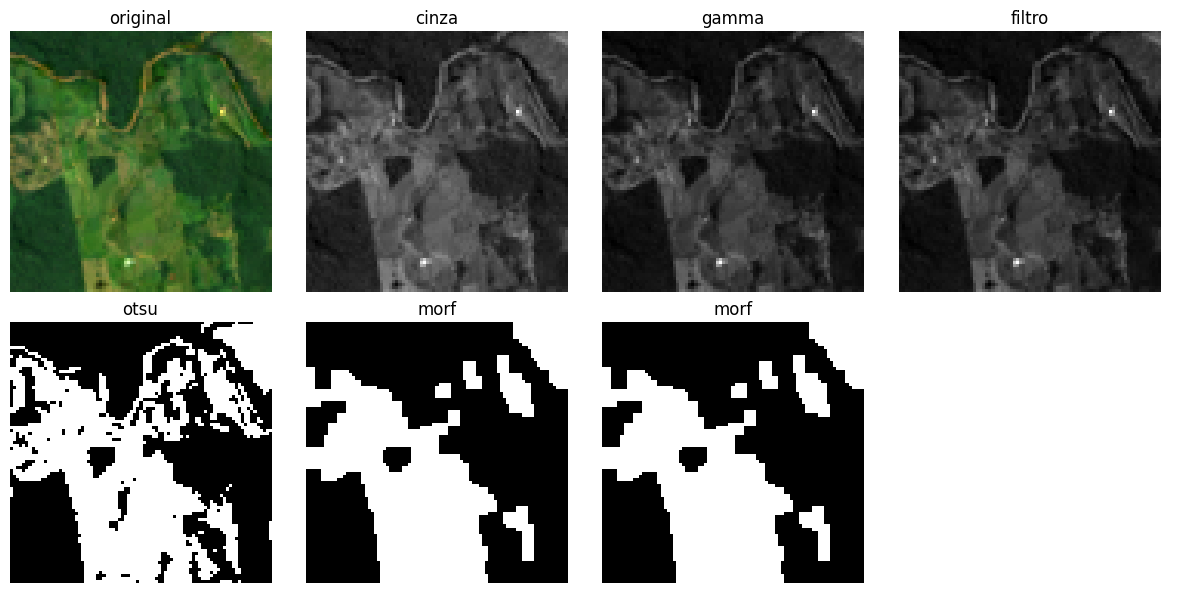


    Descricoes: ['original', 'cinza', 'gamma', 'filtro', 'otsu', 'morf', 'morf']
    Gamma: 0.75
    Filter: original
    IsMorf: False
    


In [26]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(img_list, titles=None, cmap='gray'):
    n = len(img_list)
    cols = min(4, n)  # no máximo 5 colunas
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))

    # Garantir que 'axes' seja sempre 2D array-like
    axes = np.array(axes).reshape(-1)

    for i in range(n):
        ax = axes[i]
        img,desc = img_list[i]
        ax.set_title(desc)
        ax.imshow(img, cmap=cmap)
        if titles:
            ax.set_title(titles[i])
        ax.axis('off')

    # Esconder os eixos extras, se houver
    for j in range(n, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


r1 = resultados_primeira_imagem[0]
show_images(r1.get_imgs())
print(r1)

In [ ]:
## Fazendo com todo o dataset
resultados = []
selem = morphology.square(4)
for i,(source_data, target_data) in enumerate(tqdm(dataset, desc="Vetorizando Imagens")):
  img_results = pipeline(source_data,target_data,selem)
  resultados.extend(img_results)
df = IMGs2Dataframe(resultados)

/tmp/ipython-input-15-616947673.py:3: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem = morphology.square(4)
Vetorizando Imagens:  94%|█████████▍| 9597/10224 [17:41<56:51,  5.44s/it]  